In [ ]:
#import packages
import warnings
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pystac_client
import xarray as xr
import geopandas as gpd
import folium
from shapely import wkb
import io

# ignore warnings
warnings.filterwarnings("ignore")

In [2]:
# Setup the URL to STAC catalog in Google Cloud
catalog = pystac_client.Client.open(
    'https://storage.googleapis.com/coclico-data-public/coclico/coclico-stac-15apr25/catalog.json'
    )

# Retrieve collection from catalog
collection = catalog.get_child(id = 'cba_hr')

In [29]:
#load data from STAC in DataFrame
items_ar5 = list(collection.get_items())
item_245 = items_ar5[1] 
item_126 = items_ar5[0] 
item_585 = items_ar5[2]
#print(item.assets.keys())

asset_245 = item_245.assets["data"] 
asset_126 = item_126.assets["data"]
asset_585 = item_585.assets["data"]  
#print(asset.href)

df_ssp245 = pd.read_parquet(asset_245.href)
df_ssp126 = pd.read_parquet(asset_126.href)
df_ssp585 = pd.read_parquet(asset_585.href)


In [4]:
#function to plot adaptation pathway
def plot_adaptation_pathway(df, fpid):
        df2 = df[df['fpid'] == fpid]

        fig, ax = plt.subplots()

        ax.set_xlabel("Years")
        ax.set_ylabel("Height (m)")
        ax.set_title(f"Economically optimal adaptation pathway for floodplain {fpid}")
        ax.set_xlim(2020, 2150)

        # Vertical line at 2020
        ax.plot([2020, 2020], [0, 0], color="black")

        # Loop through the years
        years = df2['year'].values
        for i in range(len(years) - 1):
                t = years[i]
                t_next = years[i + 1]

                # Retreat height
                retreat_height = df2[df2['year'] == t]['retreat_height'].values[0]
                retreat_height_next = df2[df2['year'] == t_next]['retreat_height'].values[0]
                ax.plot([t, t_next, t_next], [retreat_height, retreat_height, retreat_height_next], 
                        color='deepskyblue', linewidth=3, label="Retreat" if i == 0 else "")

                # Protection height
                protection_height = round(df2[df2['year'] == t]['protection_height'].values[0], 1)
                protection_height_next = df2[df2['year'] == t_next]['protection_height'].values[0]
                ax.plot([t, t_next, t_next], [protection_height, protection_height, protection_height_next], 
                        color='red', linewidth=2, label="Protection" if i == 0 else "")

                # Accommodation height
                acc_height = df2[df2['year'] == t]['accommodation'].values[0]
                acc_height_next = df2[df2['year'] == t_next]['accommodation'].values[0]
                acc_height = -0.1 if acc_height == 0 else acc_height
                acc_height_next = -0.1 if acc_height_next == 0 else acc_height_next
                ax.plot([t, t_next, t_next], [acc_height, acc_height, acc_height_next], 
                        color='orange', linewidth=2, label="Accommodation" if i == 0 else "")

        # Add legend
        ax.legend()
        plt.tight_layout()
        plt.show()
        return fig, ax

In [5]:
#function to plot interactive map of all floodplains
def plot_interactive_fpid_geometries(df, fpid):
    # Step 1: Drop duplicates and convert WKB to Shapely
    unique_geometries = df.drop_duplicates(subset=['fpid', 'geometry']).copy()
    unique_geometries['geometry'] = unique_geometries['geometry'].apply(wkb.loads)

    # Step 2: Create GeoDataFrame
    gdf = gpd.GeoDataFrame(unique_geometries, geometry='geometry', crs="EPSG:4326")

    # Step 3: Get center of target geometry for initial map zoom
    target_geom = gdf[gdf['fpid'] == fpid].geometry.iloc[0]
    centroid = target_geom.centroid
    center = [centroid.y, centroid.x]

    # Step 4: Create Folium map centered at target fpid
    m = folium.Map(location=center, zoom_start=12, tiles="cartodbpositron")

    # Step 5: Add all geometries with hover tooltip
    for _, row in gdf.iterrows():
        color = "red" if row["fpid"] == fpid else "gray"
        folium.GeoJson(
            row["geometry"],
            tooltip=f"fpid: {row['fpid']}",
            style_function=lambda x, color=color: {
                "fillColor": color,
                "color": "black",
                "weight": 1,
                "fillOpacity": 0.5 if color == "gray" else 0.9,
            }
        ).add_to(m)

    return m

In [ ]:
#constructing interactive map with zoom and hover function to see all floodplains with their ID's (fpid) with one fpid highlighted in red (3 mins runtime) 
interactive_map = plot_interactive_fpid_geometries(df_ssp245, fpid=34110)
interactive_map

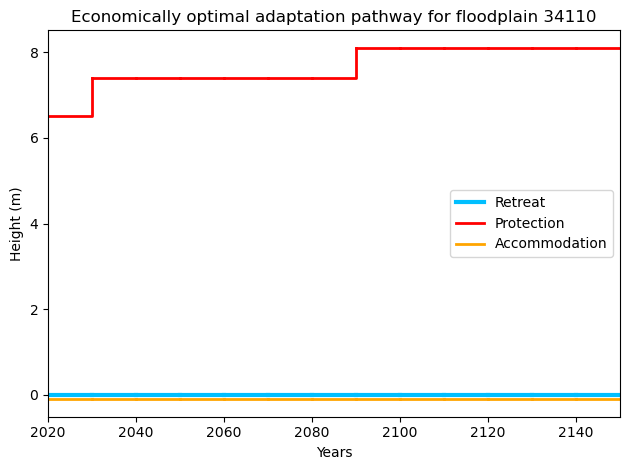

(<Figure size 640x480 with 1 Axes>,
 <Axes: title={'center': 'Economically optimal adaptation pathway for floodplain 34110'}, xlabel='Years', ylabel='Height (m)'>)

In [35]:
#plot adaptation pathway of one fpid
plot_adaptation_pathway(df_ssp245, 34110)

In [ ]:
#function to plot non-interactive map of all floodplains with one ID highlighted
def plot_fpid_geometries(df, fpid):
    # Step 1: Remove duplicate rows for each fpid (since there are 14 identical rows for each fpid)
    unique_geometries = df.drop_duplicates(subset=['fpid', 'geometry'])
    # Step 2: Convert binary WKB data to Shapely geometry objects for all unique geometries
    unique_geometries['geometry'] = unique_geometries['geometry'].apply(lambda x: wkb.loads(x))
    
    #Extract the target fpid's geometry
    target_geom = unique_geometries.loc[unique_geometries['fpid'] == fpid, 'geometry'].iloc[0]
    # Convert the binary WKB data to a shapely geometry object
    #target_geometry = wkb.loads(target_geom)

    #Plot all unique geometries, highlight target fpid
    fig, ax = plt.subplots(figsize=(8, 6))
    
    # Plot all unique geometries in a lighter color (e.g., gray)
    unique_geom_gs = gpd.GeoSeries(unique_geometries['geometry'])
    unique_geom_gs.plot(ax=ax, color="black", edgecolor="black", alpha=0.5)
    
    #Plot the target fpid in a distinct color (e.g., red)
    target_geom_gs = gpd.GeoSeries([target_geom])
    target_geom_gs.plot(ax=ax, color="red", edgecolor="red", label=f"fpid {fpid}")
    
    # Add axis labels
    ax.set_xlabel("Longitude")
    ax.set_ylabel("Latitude")
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_facecolor("white")
    ax.grid(False)
    
    # Show legend
    ax.legend()

    plt.tight_layout()
    plt.show()

    return fig, ax

In [ ]:
#plot all floodplains with one floodplain "fpid" highlighted in red
plot_fpid_geometries(df_ssp245,34110)